<a href="https://colab.research.google.com/github/Esselle7/Model-Identification-with-Sindy/blob/main/SindyTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementazione e Testing SINDy

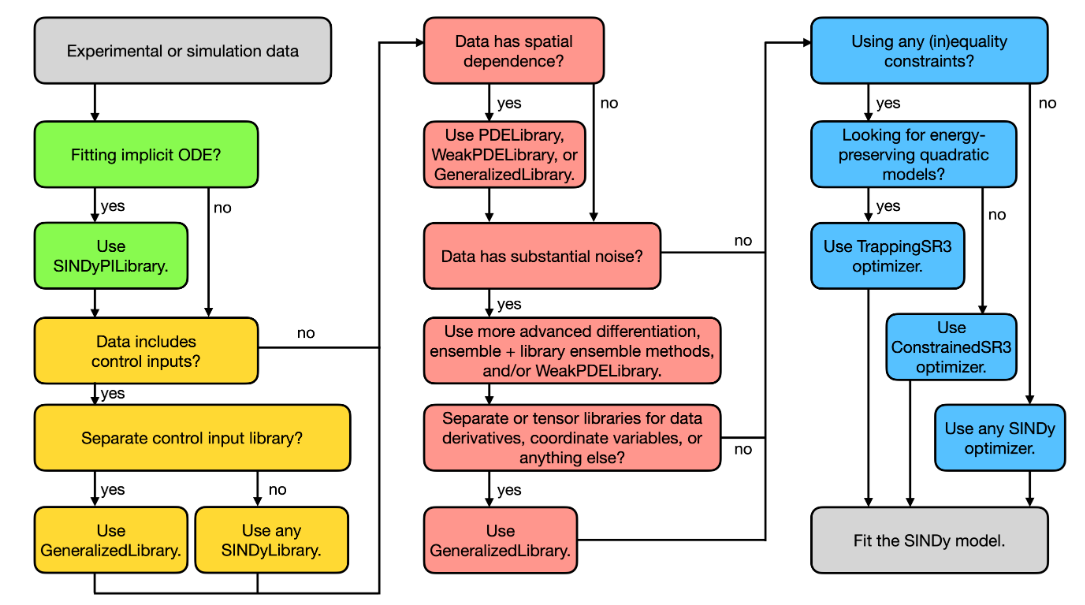

## Installo ed importo le librerie necessarie, definisco funzioni di utilità

In [ ]:
!pip install pysindy

In [ ]:
import matplotlib.pyplot as plt
import math
from typing import List
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from pysindy.utils import linear_damped_SHO
from pysindy.utils import cubic_damped_SHO
from pysindy.utils import linear_3D
from pysindy.utils import hopf
from pysindy.utils import lorenz
from sklearn.metrics import mean_squared_error
from scipy.signal import medfilt
import pysindy as ps
import csv

In [ ]:
def plot_versus(t_val, t_test, x_learned, x_test):
    plt.figure()
    plt.plot(t_val, x_learned, label='Modello appreso', color='red')
    plt.plot(t_test, x_test, label='Dati reali', linestyle='--',color='blue')
    plt.xlabel('Tempo')
    plt.ylabel('Valore')
    plt.title('Confronto tra dati reali e modello appreso')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def plot_versus_features(x_train, t_train, x_learned, feature_names):
  for i in range(x_train.shape[1]):
    plt.figure(figsize=(10, 6))

    # Plot dei dati reali
    plt.plot(t_train, x_train[:, i], label=f'Dati reali - {feature_names[i]}', linestyle='--', color='blue')

    # Plot della simulazione
    plt.plot(t_train, x_learned[:, i], label=f'Simulato - {feature_names[i]}', color='red')

    plt.xlabel('Tempo')
    plt.ylabel('Valore')
    plt.title(f'Simulazione e dati reali per {feature_names[i]}')
    plt.legend()
    plt.grid(True)
    plt.show()


##Inclusione di script dalla documentazione ufficiale

In [ ]:
!pip install git+https://github.com/dynamicslab/pysindy.git

  Cloning https://github.com/dynamicslab/pysindy.git to /tmp/pip-req-build-z1zmvky4
  Running command git clone --filter=blob:none --quiet https://github.com/dynamicslab/pysindy.git /tmp/pip-req-build-z1zmvky4
  Resolved https://github.com/dynamicslab/pysindy.git to commit 098d2312522e21f01c159e34ddbae58c37f94b03
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from pysindy.feature_library import GeneralizedLibrary

##Apprendimento dei modelli

In questa sezione, definisco i modelli noti che verranno appresi mediante un metodo didata-driven learning (SINDy).
Successivamente, genero dei dati sintetici all'interno di un intervallo di tempo determinato utilizzando questi modelli noti. Questi dati sintetici costituiranno il training set per il metodo di identificazione dei modelli SINDy. Dopo aver completato l'addestramento, eseguirò una simulazione per confrontare i risultati ottenuti con quelli generati dai modelli noti al fine di valutare l'efficacia del metodo di identificazione del modello. Tale valutazione sarà condotta attraverso lo studio dell'errore quadratico medio (MSE).

### HRI - busy_model

In [ ]:
# Importo il modello
def busy_model(interval, F_0):
    N_1 = (0.004, 0.0004, 100)
    lambda_val = N_1[0]
    t_0 = interval[0]
    return [1 - (1 - F_0) * math.exp(-lambda_val * (t - t_0)) for t in interval]

# Valore iniziale del modello preso da L*SHA
F_0 = 0.5

In [ ]:
# Definisco l'intervallo di tempo
t_val = np.linspace(0, 2000, 45)
t_train_test = np.linspace(0, 2000, 45)

# Genero i dati utilizzando la funzione busy_model
x_train = np.array(busy_model(t_train_test, F_0))
x_test = np.array(busy_model(t_train_test, F_0+0.2))

In [ ]:
# Crea un modello PySINDy
stlsq_optimizer = ps.STLSQ(threshold=0.0005)
model = ps.SINDy(optimizer=stlsq_optimizer) # che cosa ritorna questo costruttore, vettore di coeff e library funct.
model.fit(x_train, t_train_test, quiet=True)
model.print() # metodi di equivalenza tra parametri del modello (come misurare distanza tra funzioni).

(x0)' = 0.004 1 + -0.004 x0


In [ ]:
# Genero i valori dal modello appreso partendo dalo stesso valore iniziale del modello noto
init_val = np.array([x_test[0]])
x_learned = model.simulate(init_val, t_val)

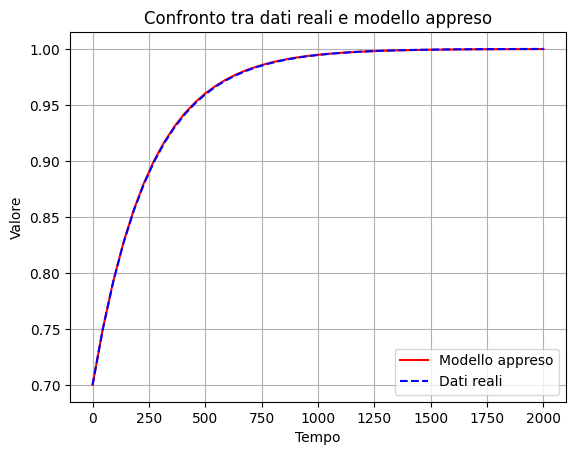

Model score: 0.999917


In [ ]:
# Plotto il grafico del modello reale e del modello appreso
plot_versus(t_val, t_train_test, x_learned, x_test)
print("Model score: %f" % model.score(x_test, t_train_test))

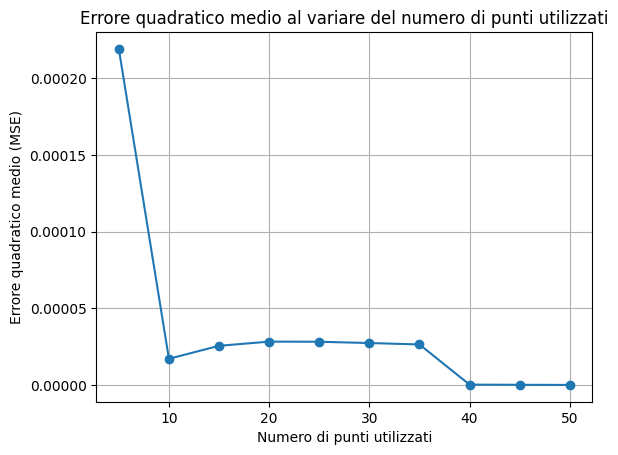

In [ ]:
mse_list = []


for num_point in range(5, 55, 5):  # valori da 5 a 101 con incrementi di 5
    t = np.linspace(0, 2000, num_point)
    x_train = np.array(busy_model(t, F_0))
    x_test = np.array(busy_model(t, F_0+0.2))
    model = ps.SINDy(optimizer=ps.STLSQ(threshold=0.0005))
    model.fit(x_train, t)
    x_learned = model.simulate(np.array([x_test[0]]), t)
    # Calcola l'errore quadratico medio
    mse = mean_squared_error(x_test, x_learned, squared=True)
    # Aggiungi l'MSE alla lista
    mse_list.append(mse)

# Plot dell'errore quadratico medio rispetto al numero di punti utilizzati
plt.figure()
plt.plot(range(5, 55, 5), mse_list, marker='o')
plt.xlabel('Numero di punti utilizzati')
plt.ylabel('Errore quadratico medio (MSE)')
plt.title('Errore quadratico medio al variare del numero di punti utilizzati')
plt.grid(True)
plt.show()


In [ ]:
def plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test):
    dt = t_test[1] - t_test[0]
    mse = np.zeros(len(threshold_scan))
    mse_sim = np.zeros(len(threshold_scan))
    for i in range(len(threshold_scan)):
        opt.coef_ = coefs[i]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
        x_test_sim = model.simulate(x_test[0], t_test, integrator="odeint")
        if np.any(x_test_sim > 1e4):
            x_test_sim = 1e4
        mse_sim[i] = np.sum((x_test - x_test_sim) ** 2)
    plt.figure()
    plt.semilogy(threshold_scan, mse, "bo")
    plt.semilogy(threshold_scan, mse, "b")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"$\lambda$", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.figure()
    plt.semilogy(threshold_scan, mse_sim, "bo")
    plt.semilogy(threshold_scan, mse_sim, "b")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"$\lambda$", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)

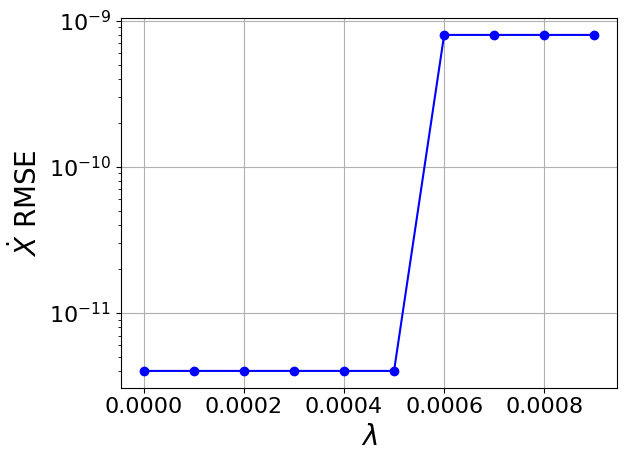

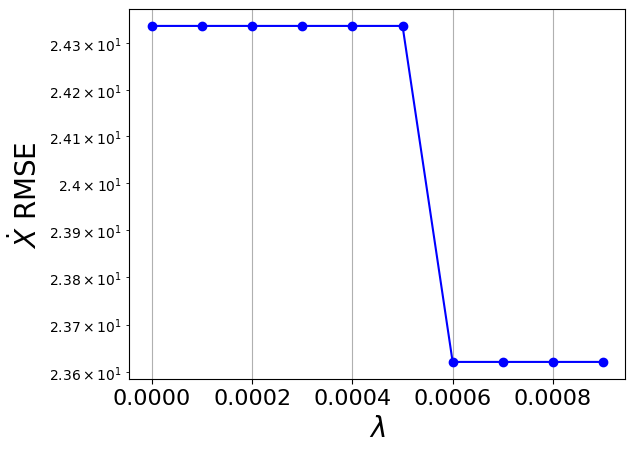

In [ ]:
threshold_scan = np.arange(0, 0.001, 0.0001)
coefs = []
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train + np.random.normal(0, rmse / 10.0,  x_train.shape)
for i, threshold in enumerate(threshold_scan):
    opt = ps.STLSQ(threshold=threshold)
    model = ps.SINDy(optimizer=opt)
    model.fit(x_train, t)
    coefs.append(model.coefficients())

plot_pareto(coefs, opt, model,
            threshold_scan, x_test, t)

### THERMOSTAT - on_model

In [ ]:
# Importo la classe Timestamp da L*SHA con le relative costanti
DAYS_PER_MONTH = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
CLOSED_R = 100.0
OFF_DISTR = (100.0, 1.0, 200)
ON_DISTR = (0.7, 0.01, 200)
class Timestamp:
    def __init__(self, y: int, m: int, d: int, h: int, min: int, sec: float):
        self.year = y
        self.month = m
        self.day = d
        self.hour = h
        self.min = min
        self.sec = sec

    @staticmethod
    def from_secs(secs: int):
        new_ts = Timestamp(int(secs / (365 * 24 * 3600)), 0, 0, 0, 0, 0)
        if secs > 365 * 24 * 3600:
            secs -= new_ts.year * 365 * 24 * 3600
        sum_d = 0
        for i, month_d in enumerate(DAYS_PER_MONTH):
            sum_d += month_d
            if secs <= sum_d * 24 * 3600:
                new_ts.month = i + 1
                secs -= (sum_d - month_d) * 24 * 3600
                break
        new_ts.day = int(secs / (24 * 3600)) + 1
        secs -= (new_ts.day - 1) * 24 * 3600
        new_ts.hour = int(secs / 3600)
        secs -= new_ts.hour * 3600
        new_ts.min = int(secs / 60)
        new_ts.sec = secs - new_ts.min * 60
        return new_ts

    def to_secs(self):
        months = sum(DAYS_PER_MONTH[:self.month - 1]) if self.month > 0 else 0
        days = self.year * 365 + months + self.day - 1 if self.day > 0 else 0
        minutes = self.hour * 60 + self.min
        seconds = minutes * 60 + self.sec
        return days * 24 * 3600 + seconds

    def __str__(self):
        return '{}/{}/{} {}:{}:{}'.format(self.day, self.month, self.year, self.hour, self.min, self.sec)

    def __hash__(self):
        return hash(str(self))

    def __eq__(self, other):
        return self.to_secs() == other.to_secs()

    def __ge__(self, other):
        return self.to_secs() >= other.to_secs()

    def __lt__(self, other):
        return self.to_secs() < other.to_secs()

    def __sub__(self, other):
        return self.to_secs() - other.to_secs()

In [ ]:
# Importo il modello
def on_model(interval: List[Timestamp], T_0: float):
    interval = [ts.to_secs() for ts in interval]
    coeff = CLOSED_R * ON_DISTR[0]
    return [coeff - (coeff - T_0) * math.exp(-(1 / CLOSED_R) * (t - interval[0])) for t in interval]
# Definisco la temperatura iniziale
T_0 = 10

In [ ]:
# Definisco l'intervallo di tempo
t_val = np.linspace(0, 500, 45)
t_train_test = np.linspace(0, 500, 100)

# Creazione di una lista di oggetti Timestamp
timestamps = []
for time in t_train_test:
    timestamp = Timestamp.from_secs(int(time))
    timestamps.append(timestamp)

# Utilizzo della lista di timestamp nella funzione on_model
x_train = np.array(on_model(timestamps, T_0))
x_test = np.array(on_model(timestamps, T_0+5))


# Creo un modello PySINDy polinomiale questa volta di grado 1
model = ps.SINDy(optimizer=ps.STLSQ(threshold=0.002))

model.fit(x_train, t_train_test)
model.print()

(x0)' = 0.695 1 + -0.010 x0


In [ ]:
# Genero i valori dal modello appreso partendo dalo stesso valore iniziale del modello noto
init_val = np.array([x_test[0]])
x_learned = model.simulate(init_val, t_val)

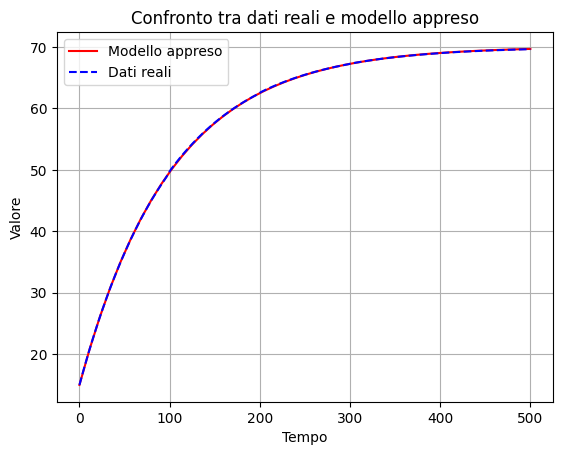

Model score: 0.999514


In [ ]:
# Plotta il grafico del modello reale e del modello appreso
plot_versus(t_val, t_train_test, x_learned, x_test)
print("Model score: %f" % model.score(x_test, t_train_test))

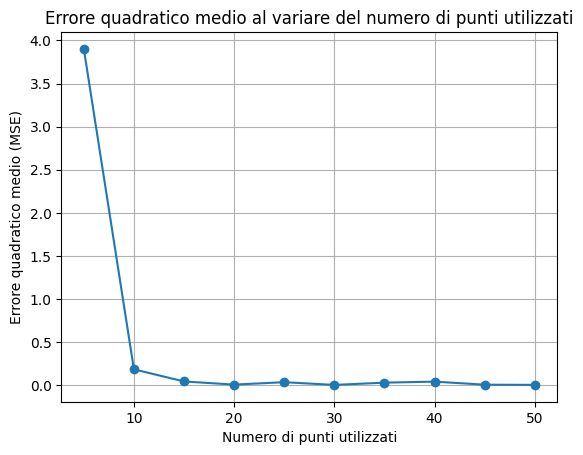

In [ ]:
mse_list = []


for num_points in range(5, 55, 5):  # valori da 5 a 101 con incrementi di 5
    t = np.linspace(0, 500, num_points)
    timestamps = []
    for time in t:
      timestamp = Timestamp.from_secs(int(time))
      timestamps.append(timestamp)
    x_train = np.array(on_model(timestamps, T_0))
    x_test = np.array(on_model(timestamps, T_0+5))
    model = ps.SINDy(optimizer=ps.STLSQ(threshold=0.002))
    model.fit(x_train, t)
    x_learned = model.simulate(np.array([x_test[0]]), t)
    mse = mean_squared_error(x_test, x_learned, squared=True)
    mse_list.append(mse)

# Plot dell'errore quadratico medio rispetto al numero di punti utilizzati
plt.figure()
plt.plot(range(5, 55, 5), mse_list, marker='o')
plt.xlabel('Numero di punti utilizzati')
plt.ylabel('Errore quadratico medio (MSE)')
plt.title('Errore quadratico medio al variare del numero di punti utilizzati')
plt.grid(True)
plt.show()


## Problematiche aperte

### Scelta di iperparametri

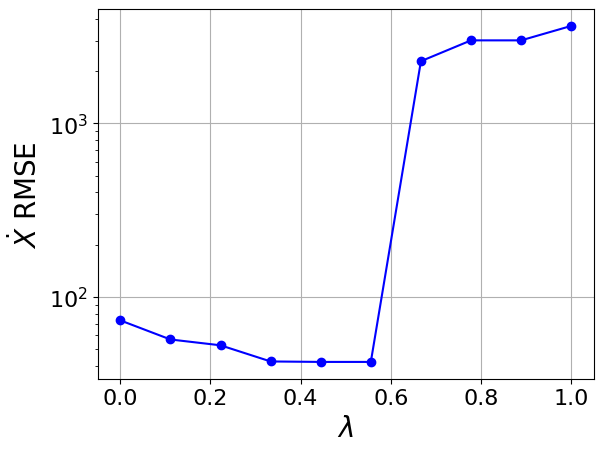

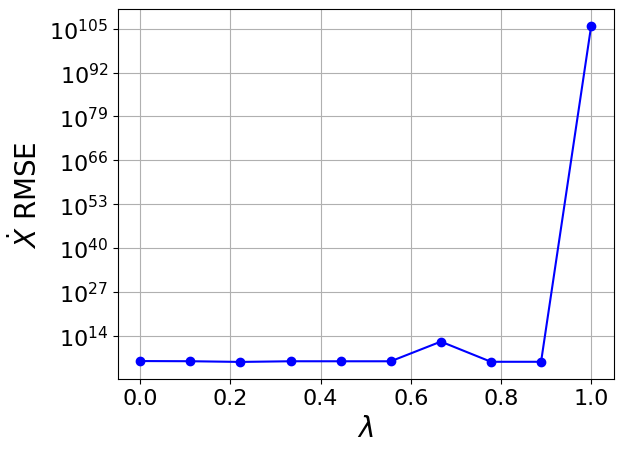

In [ ]:
# Esempio con sistema di tre ODE (Lorentz)
# define the testing and training Lorenz data we will use for these examples

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12
dt = 0.002
feature_names = ['x', 'y', 'z']
t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
t_train_span = (t_train[0], t_train[-1])
x_train = solve_ivp(
    lorenz, t_train_span, x0_train, t_eval=t_train, **integrator_keywords
).y.T

t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = np.array([8, 7, 15])
x_test = solve_ivp(
    lorenz, t_test_span, x0_test, t_eval=t_test, **integrator_keywords
).y.T

threshold_scan = np.linspace(0, 1.0, 10)
coefs = []
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train + np.random.normal(0, rmse / 10.0,  x_train.shape)
for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.STLSQ(threshold=threshold)
    model = ps.SINDy(feature_names=feature_names,
                     optimizer=sparse_regression_optimizer)
    model.fit(x_train_added_noise, t=dt, quiet=True)
    coefs.append(model.coefficients())

plot_pareto(coefs, sparse_regression_optimizer, model,
            threshold_scan, x_test, t_test)

### Funzioni candidate di libreria per l'approssimazione (qui usato solo Polinomiali)

In [ ]:
# Inizializza librerie polinomiali, cos/sin e reciproci+esponenziali
poly_library = ps.PolynomialLibrary()
fourier_library = ps.FourierLibrary()
library_functions = [lambda x: 1.0 / (x + 100), lambda x: np.exp(-x)]
library_function_names = [
    lambda x: "1.0 / (" + x + " + 100)",
    lambda x: "exp(-" + x + ")",
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names
)

# Inizializza input per ogni libreria
inputs_temp = np.tile([0, 1, 2, 3, 4], 3)
inputs_per_library = np.reshape(inputs_temp, (3, 5))

# Escludo x, u0, u1 inputs per Fourier
inputs_per_library[1, 2] = 1
inputs_per_library[1, 3] = 1
inputs_per_library[1, 4] = 1

# Escludo y, z, u0 inputs per la Custom Library
inputs_per_library[2, 1] = 0
inputs_per_library[2, 2] = 0
inputs_per_library[2, 3] = 0

# Per fare prodotto tra polynomial e Fourier library
# e tra Fourier e Custom library.
tensor_array = [[1, 1, 0], [0, 1, 1]]

# Inizializzo la Generalized Library da poter utilizzare
generalized_library = ps.GeneralizedLibrary(
    [poly_library, fourier_library, custom_library],
    tensor_array=tensor_array,
    inputs_per_library=inputs_per_library,
)

## Test ENERGY DATASET

quando cambia la velocità vuol dire che tool è fermo e
ripartio,m usiamo come eventi
(a seconda della velocità fa cose diverse)
sp velocità mandrino

RICORDA CHE DEVI SEMPRE SEMPLIFICARE E RIDURRE ALL'OSSO! NON SERVONO COSE TROPPO COMPLICATE.
A questo punto devi modificar ela generalized library per accettare un solo input. In più poi devi vedere se sei riuscito a fittare diversi modelli. più sotto.

In [ ]:
# Importo la classe Timestamp da L*SHA con le relative costanti
DAYS_PER_MONTH = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
CLOSED_R = 100.0
OFF_DISTR = (100.0, 1.0, 200)
ON_DISTR = (0.7, 0.01, 200)
class Timestamp:
    def __init__(self, y: int, m: int, d: int, h: int, min: int, sec: float):
        self.year = y
        self.month = m
        self.day = d
        self.hour = h
        self.min = min
        self.sec = sec

    @staticmethod
    def from_secs(secs: int):
        new_ts = Timestamp(int(secs / (365 * 24 * 3600)), 0, 0, 0, 0, 0)
        if secs > 365 * 24 * 3600:
            secs -= new_ts.year * 365 * 24 * 3600
        sum_d = 0
        for i, month_d in enumerate(DAYS_PER_MONTH):
            sum_d += month_d
            if secs <= sum_d * 24 * 3600:
                new_ts.month = i + 1
                secs -= (sum_d - month_d) * 24 * 3600
                break
        new_ts.day = int(secs / (24 * 3600)) + 1
        secs -= (new_ts.day - 1) * 24 * 3600
        new_ts.hour = int(secs / 3600)
        secs -= new_ts.hour * 3600
        new_ts.min = int(secs / 60)
        new_ts.sec = secs - new_ts.min * 60
        return new_ts

    def to_secs(self):
        months = sum(DAYS_PER_MONTH[:self.month - 1]) if self.month > 0 else 0
        days = self.year * 365 + months + self.day - 1 if self.day > 0 else 0
        minutes = self.hour * 60 + self.min
        seconds = minutes * 60 + self.sec
        return days * 24 * 3600 + seconds

    def __str__(self):
        return '{}/{}/{} {}:{}:{}'.format(self.day, self.month, self.year, self.hour, self.min, self.sec)

    def __hash__(self):
        return hash(str(self))

    def __eq__(self, other):
        return self.to_secs() == other.to_secs()

    def __ge__(self, other):
        return self.to_secs() >= other.to_secs()

    def __lt__(self, other):
        return self.to_secs() < other.to_secs()

    def __sub__(self, other):
        return self.to_secs() - other.to_secs()
class SignalPoint:
    def __init__(self, t: Timestamp, val: float):
        self.timestamp = t
        self.value = val

    def __str__(self):
        return '{}: {}'.format(self.timestamp, self.value)

    def __eq__(self, other):
        return self.timestamp == other.timestamp and self.value == other.value


class SampledSignal:
    def __init__(self, pts: List[SignalPoint], label=None):
        self.label = label
        self.points = pts

def parse_ts(string: str):
    date = string.split('T')[0]
    year = int(date[0:4])
    month = int(date[5:7])
    day = int(date[8:10])
    time = string.split('T')[1].split('Z')[0]
    hour = int(time[0:2])
    minute = int(time[3:5])
    second = int(time[6:8])
    return Timestamp(year, month, day, hour, minute, second)

In [ ]:
def parse_data(path: str):
    # support method to parse traces sampled by ref query
    power: SampledSignal = SampledSignal([], label='P')
    speed: SampledSignal = SampledSignal([], label='w')
    pressure: SampledSignal = SampledSignal([], label='pr')
    toolID: SampledSignal = SampledSignal([], label='id')
    speed_derivative: SampledSignal = SampledSignal([], label='wd')

    with open(path) as csv_file:
        reader = csv.DictReader(csv_file, delimiter=';')

        for i, row in enumerate(reader):
            # to skip the columns name row
            if i == 0:
                continue

            # select the timestamp from column 0
            ts = parse_ts(row['_time'])

            # parse power value
            power.points.append(SignalPoint(ts, float(row['Total_power'])))

            # parse speed value: round to closest [100]
            speed_v = round(float(row['actual_Speed_SP1']) / 100) * 100
            speed.points.append(SignalPoint(ts, speed_v))

            # parse pallet pressure value
            pressure.points.append(SignalPoint(ts, float(row['Pressure'])))

            # parse tool ID value
            toolID.points.append(SignalPoint(ts, float(row['dictID'])))

            # parse a signal which represents the derivative of the speed vector
            if i > 0:
                if round(speed.points[i-2].value) == round(speed.points[i-1].value):  # if constant
                    speed_d = 0
                elif round(speed.points[i-2].value) < round(speed.points[i-1].value):  # if going up
                    speed_d = 1
                else:  # if going down
                    speed_d = -1
                speed_derivative.points.append(SignalPoint(ts, float(speed_d)))

        return [power, speed, pressure, toolID, speed_derivative]

In [ ]:
def plot_signal(points, title):
    timestamps = [str(point.timestamp).split(' ', 1)[1] for point in points]
    values = [point.value for point in points]

    plt.figure(figsize=(10, 6))
    plt.plot(timestamps, values)
    plt.title(title)
    plt.xlabel('Tempo')
    plt.ylabel('Valore')
    plt.xticks(timestamps[::30])
    plt.grid(True)
    plt.show()

In [ ]:
def transform_times_to_seconds_cumulative(times):
    # Converte i tempi nel formato 'HH:MM:SS' in secondi totali
    times_seconds = [sum(int(x) * 60**i for i, x in enumerate(reversed(time.split(':')))) for time in times]

    # Calcola il tempo cumulativo trascorso dal primo elemento
    times_transformed = [time - times_seconds[0] for time in times_seconds]

    return np.array(times_transformed)

In [ ]:
# Creazione di x_train
def extractValues(points):
   return [point.value for point in points]

def extractTimestamps(points):
  return [str(point.timestamp).split(' ', 1)[1] for point in points]

In [ ]:
def numericFilter(x, t):
  x_filtered = []
  t_filtered = []

  for riga_x, ts in zip(x, t):
      x_row = []
      t_row = ts

      for x in riga_x:
          if isinstance(x, (int, float)):
              x_row.append(x)

      if x_row:
          x_filtered.append(x_row)
          t_filtered.append(t_row)

  return x_filtered, t_filtered

In [ ]:
def generateSingleTrainTimeData(path, time):
  signals = parse_data(path)
  power_signal, speed_signal, pressure_signal, tool_id_signal, speed_derivative_signal = signals

# Traccia il grafico per ogni variabile
  #plot_signal(power_signal.points, "Potenza")
  #plot_signal(speed_signal.points, "Velocità")
  #plot_signal(pressure_signal.points, "Pressione")

  power_points = power_signal.points
  speed_points = speed_signal.points
  pressure_points = pressure_signal.points
  power_values = extractValues(power_points)
  speed_values = extractValues(speed_points)
  pressure_values = extractValues(pressure_points)
  x_train = np.column_stack([
    power_values,
    speed_values,
    pressure_values
  ])
  t_train_timestamps = np.array(extractTimestamps(power_points))
  t_train = transform_times_to_seconds_cumulative(t_train_timestamps)
  x_train_filtered, t_train_filtered = numericFilter(x_train, t_train)
  if time:
    return x_train_filtered, t_train_filtered
  else:
    return x_train_filtered

In [ ]:
def generateTrainTimeData():
  base_path="/content/drive/MyDrive/TESI AUTOMATA LEARNING/TRAIN/"
  data_paths = [base_path+"_03_mar_1.csv",
                base_path+"_05_may_1.csv",
                base_path+"_05_may_2.csv",
                base_path+"_11_jan_2.csv",
                base_path+"_12_apr_1.csv",
                base_path+"_12_apr_2.csv",
                base_path+"_12_jan_2.csv",
                base_path+"_12_jan_3.csv",
                base_path+"_12_jan_4.csv",
                base_path+"_12_jan_5.csv"
                ]
  train_datas = []
  time_datas = []
  first = True
  for path in data_paths:
    train_data, time_data = generateSingleTrainTimeData(path, True)
    if first:
      train_datas.append(train_data)
      time_datas.append(time_data)
      first = False
    else:
      train_datas.append(train_data)
      time_datas.append(time_data)
  return train_datas, time_datas

In [ ]:
train_datas, time_datas = generateTrainTimeData()

In [ ]:
x_train, t_train = generateSingleTrainTimeData("/content/drive/MyDrive/TESI AUTOMATA LEARNING/TRAIN/_03_mar_1.csv", True)

In [ ]:
x_test, t_test = generateSingleTrainTimeData("/content/drive/MyDrive/TESI AUTOMATA LEARNING/TRAIN/_05_may_1.csv", True)

In [ ]:
# Verifica le dimensioni degli array
print("Dimensioni di x_train:", x_train.shape)
print("Dimensioni di t_train:", t_train.shape)
print("Dimensioni di x_test:", x_test.shape)
print("Dimensioni di t_test:", t_test.shape)

Dimensioni di x_train: (311, 4)
Dimensioni di t_train: (311,)
Dimensioni di x_test: (405, 4)
Dimensioni di t_test: (405,)


In [ ]:
# Initialize three libraries
poly_library = ps.PolynomialLibrary()
fourier_library = ps.FourierLibrary()
library_functions = [lambda x: 1.0 / (x + 100), lambda x: np.exp(-x)]
library_function_names = [
    lambda x: "1.0 / (" + x + " + 100)",
    lambda x: "exp(-" + x + ")",
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names
)


# Initialize the default inputs, i.e. each library
# uses all the input variables, (5 inputs and 3 libraries here)
inputs_temp = np.tile([0, 1, 2], 3)
inputs_per_library = np.reshape(inputs_temp, (3, 3))

# Don't use the x, u0, u1 inputs for generating the Fourier library
inputs_per_library[1, 2] = 1

# Don't use the y, z, u0 inputs for generating the custom library
inputs_per_library[2, 1] = 0
inputs_per_library[2, 2] = 0

# Tensor all the polynomial and Fourier library terms together
# and tensor all the Fourier and Custom library terms together.
tensor_array = [[1, 1, 0], [0, 1, 1]]

# Initialize this generalized library, all the work hidden from the user!
generalized_library = ps.GeneralizedLibrary(
    [poly_library, fourier_library, custom_library],
    tensor_array=tensor_array,
    inputs_per_library=inputs_per_library,
)

In [ ]:
feature_names = ['Power', 'Speed', 'Pressure']
STLSQ_optimizer = ps.STLSQ(threshold=0.00002)
#sr3_optimizer = ps.SR3(threshold=0.01, thresholder="l0")
for x_val, t_val in zip(train_datas, time_datas):
  x_train = np.array(x_val)
  t_train = np.array(t_val)
  model_power = ps.SINDy(feature_names=np.array(feature_names[0]),feature_library=generalized_library,optimizer=STLSQ_optimizer)
  model_power.fit(x_train[:,0], t=t_train)
  model_power.print()
  model_speed = ps.SINDy(feature_names=np.array(feature_names[1]),feature_library=generalized_library,optimizer=STLSQ_optimizer)
  model_speed.fit(x_train[:,1], t=t_train)
  model_speed.print()
  model_pressure = ps.SINDy(feature_names=np.array(feature_names[2]),feature_library=generalized_library,optimizer=STLSQ_optimizer)
  model_pressure.fit(x_train[:,2], t=t_train)
  model_pressure.print()

/usr/local/lib/python3.10/dist-packages/pysindy/utils/axes.py:126: AxesWarning: 2 axes labeled for array with 1 axes
  warnings.warn(


ValueError: Each row in inputs_per_library must consist of integers between 0 and the number of total input features - 1. 

In [ ]:
feature_names = ['Power', 'Speed', 'Pressure']

STLSQ_optimizer = ps.STLSQ(threshold=0.002)
sr3_optimizer = ps.SR3(threshold=0.01, thresholder="l0")

model = ps.SINDy(feature_names=feature_names,feature_library=generalized_library,optimizer=sr3_optimizer)
model.fit(x_train, t=t_train)
model.print()

(Power)' = 3.338 1 + 3.073 Power + -0.013 Speed + 2.956 Pressure + 4.195 ToolID + -18.554 Power^2 + 0.014 Power Speed + 3.073 Power Pressure + 0.567 Power ToolID + -0.013 Speed Pressure + 2.956 Pressure^2 + 4.208 Pressure ToolID + -0.320 ToolID^2 + 3.498 sin(1 Power) + -4.506 cos(1 Power) + 0.524 sin(1 Speed) + 2.349 cos(1 Speed) + 0.033 1.0 / (Power + 100) + -3.120 exp(-Power) + 3.498 1 sin(1 Power) + -4.506 1 cos(1 Power) + 0.524 1 sin(1 Speed) + 2.349 1 cos(1 Speed) + 16.222 Power sin(1 Power) + -8.034 Power cos(1 Power) + -0.189 Power sin(1 Speed) + -2.738 Power cos(1 Speed) + 0.013 Speed cos(1 Power) + 3.498 Pressure sin(1 Power) + -4.888 Pressure cos(1 Power) + 0.524 Pressure sin(1 Speed) + 1.967 Pressure cos(1 Speed) + -3.213 ToolID sin(1 Power) + -3.821 ToolID cos(1 Power) + -0.340 ToolID sin(1 Speed) + -0.434 ToolID cos(1 Speed) + -16.722 Power^2 sin(1 Power) + -11.291 Power^2 cos(1 Power) + -1.413 Power^2 sin(1 Speed) + 1.504 Power^2 cos(1 Speed) + 0.011 Power Speed sin(1 Pow

In [ ]:
# Simulazione di tutte le equazioni differenziali (ODE) identificate dal modello
init_val = np.array([x_test[0]])
print(init_val)
x_learned = model.simulate(x_test[0], t_test)
plot_versus_features(x_train, t_train, x_learned, feature_names)

[[0. 0. 0. 1.]]


KeyboardInterrupt: 